<a href="https://colab.research.google.com/github/PhanieDianelle/Object-tracking-using-Detectron2-/blob/main/Detectron2_Tutorial_AMMI_2023_CV_Week_2_Lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detectron2 Beginner's Tutorial -- AMMI 2023 CV Week 2 Lab 1

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Welcome to detectron2! This is the official colab tutorial of detectron2. Here, we will go through some basics usage of detectron2, including the following:
* Run inference on images or videos, with an existing detectron2 model
* Train a detectron2 model on a new dataset

You can make a copy of this tutorial by "File -> Open in playground mode" and make changes there. __DO NOT__ request access to this tutorial.


# Install detectron2

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp310-cp310-linux_x86_64.whl size=44090 sha256=e73107833a52041a51355c751239cfc95a5a4ca8074e8461cced8f49bc0ad341
  Stored in directory: /root/.cache/pip/wheels/70/83/31/975b737609aba39a4099d471d5684141c1fdc3404f97e7f68a
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.12.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
flax 0.6.9 requires PyYAML>=5.4.1, but you have pyyaml 5.1 which is incompatibl

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61405 sha256=1aa36515d466a40c6d6aeca6785d04bfc8d66e4f9f8a7e60da7b3f94038bb38b
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=9805097375b26b5706363770eae82b

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Run a pre-trained detectron2 model

We first download an image from the COCO dataset:

In [ ]:
!wget https://github.com/gkioxari/aims2020_visualrecognition/releases/download/v1.0/videoclip.zip -q -O input.jpg
im = cv2.imread("./input.zip")
im
#cv2_imshow(im)
#print(im.shape)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[05/08 15:20:09 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:01, 177MB/s]                           
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# look at the outputs. See https://detectron2.readthedocs.io/tutorials/models.html#model-output-format for specification
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([17,  0,  0,  0,  0,  0,  0,  0, 25,  0, 25, 25,  0,  0, 24],
       device='cuda:0')
Boxes(tensor([[126.6035, 244.8977, 459.8291, 480.0000],
        [251.1083, 157.8127, 338.9731, 413.6379],
        [114.8496, 268.6864, 148.2352, 398.8111],
        [  0.8217, 281.0327,  78.6072, 478.4210],
        [ 49.3953, 274.1229,  80.1545, 342.9808],
        [561.2248, 271.5816, 596.2755, 385.2552],
        [385.9072, 270.3125, 413.7130, 304.0397],
        [515.9295, 278.3743, 562.2792, 389.3803],
        [335.2409, 251.9167, 414.7491, 275.9375],
        [350.9300, 269.2060, 386.0984, 297.9081],
        [331.6292, 230.9996, 393.2759, 257.2009],
        [510.7349, 263.2656, 570.9865, 295.9194],
        [409.0841, 271.8646, 460.5582, 356.8722],
        [506.8767, 283.3257, 529.9403, 324.0392],
        [594.5663, 283.4820, 609.0577, 311.4124]], device='cuda:0'))


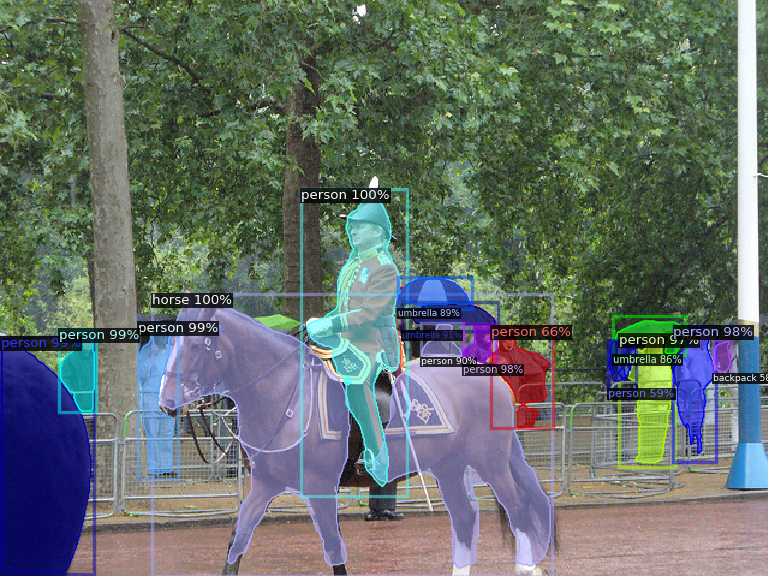

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

# Human pose estimation

In [ ]:
# Inference with a keypoint detection model
cfg = get_cfg()   # get a fresh new config

# Navigate to the Detectron2 Model Zoo and figure out a suitable model yaml configuration
# file to use. Follow the example above as a template.
# Model Zoo: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md

CONFIG_FILE = "Fill this in!"

cfg.merge_from_file(model_zoo.get_config_file(CONFIG_FILE))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(CONFIG_FILE)
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])